In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#### 1. Load the data using the the data type pandas DataFrame.
I chose to regress two models for two turbines as I don't have any further turbine information for example the hardware.

In [27]:
# Load both dataframes
raw_turbine1 = pd.read_csv('Turbine1.csv', sep=';', header=[0,1], dtype=str)
raw_turbine2 = pd.read_csv('Turbine2.csv', sep=';', header=[0,1], dtype=str)

In [28]:
# Quick check of duplicated rows
# print(raw_turbine1.duplicated().sum())
# print(raw_turbine2.duplicated().sum())

I found that there're redundant spaces in the beginning or end of column names in the dataframe. And also all the decimal numbers are in the string format with comma instead of decimal dot. I decided to merge the first two rows into a new row of header, remove the redundant spaces and also changed each data into a float with decimal dot. In addition, I changed the Dat/Zeit column into the pandas datetime format for the anomaly analysis later.

In [29]:
# Function to clean and preprocess data format
def clean_df(df):
    # Combine the first two rows into the new header and remove redundant spaces
    df.columns = [' '.join([part.strip() for part in col]).strip() for col in df.columns]
    # Transform the DateTime column into the pandas datetime format
    df.loc[:,'Dat/Zeit'] = pd.to_datetime(df['Dat/Zeit'], format='%d.%m.%Y, %H:%M')
    # replace commas with decimal dots and change data format to float number instead of strings
    df.iloc[:,1:] = df.iloc[:,1:].applymap(lambda x: float(x.replace(',','.')))
    return df

df_turbine1  = clean_df(raw_turbine1)
df_turbine2 = clean_df(raw_turbine2)

In [30]:
# Select the feature and the target
x_1 = df_turbine1[['Wind m/s']]
y_1 = df_turbine1[['Leistung kW']]
x_2 = df_turbine2[['Wind m/s']]
y_2 = df_turbine2[['Leistung kW']]

In [31]:
# Split into trainiing and test set for further evaluation
x1_train, x1_test, y1_train, y1_test = train_test_split(x_1, y_1 , test_size=0.2, random_state=22)
x2_train, x2_test, y2_train, y2_test = train_test_split(x_2, y_2 , test_size=0.2, random_state=22)

#### 2. Train any ML Model that predicts the power (single target) by a given windspeed (single feature).
I use a simple linear regression model to fit the data.

In [32]:
# Function to trian a simple linear regression model
def train_lr(x_train, y_train):
    model = LinearRegression()
    model.fit(x_train, y_train)
    return model

#### 3. Choose a good metric to measure the model performance.
I use the mean squared error as a standard metric for the linear regression task.

In [33]:
# Function to evaluate the trained regression model
def test_lr(x_test, y_test, model):
    predictions = model.predict(x_test)
    test_loss = mean_squared_error(y_test, predictions)
    return predictions, test_loss

In [34]:
# Test both models on Turbine 1 and 2
# Turbine 1 with 1 feature -> t1_f1
model_t1_f1 = train_lr(x1_train, y1_train)
model_t2_f1 = train_lr(x2_train, y2_train)
_, test_loss_t1_f1 = test_lr(x1_test, y1_test, model_t1_f1)
_, test_loss_t2_f1 = test_lr(x2_test, y2_test, model_t2_f1)
print(test_loss_t1_f1)
print(test_loss_t2_f1)

22210.228115587095
25847.709432264848


#### 4. Explain why you chose this model architecture and what the limitations of this architecture might be.

I chose a linear regression model because these two features are highly correlated to each other which is proved in the next code block where I analyzed correlation between features. Also, linear regression would be the most straightforward and intuitive method for a regression task with one feature as input. Logically speaking, the higher the windspeed is, the more power we would expect from the turbine. 

The limitation of a linear regression model is that in the end it only can learn linear functions to represent the relationships between features and target variable. So it can't model the non-linearity as a DNN since it has no such activation function. Also as I picked mean squared error as the metric, it can also be prone to outliers in the dataset.

#### 5. Try out additional features. Which features did you choose? How did the results change and why?

There're a lot of features in the dataframe. To pick meaningful ones, I first analyzed the correlation between all other features and the target feature Leistung. It turns out the 'Strom- A', 'Gen1- °C', 'Strom- A.1', 'Strom- A.2' features are also highly correlated to the power. So I picked these four additional features for the linear regression model here. As we could see from the notebook, the performance on the same test set as the first single-feature model has improved by a large margin. This is because we enable the model to have a few more parameters and take more factors into account as we added four more highly correlated features.

ps: Although I don't really know what Gen1- stands for, but that higher current leads to higher power definitely makes sense to me.

In [35]:
# get the feature dataframes
turbine1_features = df_turbine1.iloc[:,1:]
turbine2_features = df_turbine2.iloc[:,1:]
# Calculate the correlation
cor_t1 = turbine1_features.corr()
cor_t2 = turbine2_features.corr()
# Select the correlation to the target feature
cor_t1_target = abs(cor_t1['Leistung kW'])
cor_t2_target = abs(cor_t2['Leistung kW'])
# Select highly correlated features
print(cor_t1_target[cor_t1_target > 0.9])
print(cor_t2_target[cor_t2_target > 0.9])

Wind m/s       0.946330
Leistung kW    1.000000
Gen1- °C       0.931303
Strom- A       0.998496
Strom- A.1     0.998323
Strom- A.2     0.998467
Name: Leistung kW, dtype: float64
Wind m/s       0.941897
Leistung kW    1.000000
Gen1- °C       0.939169
Strom- A       0.999226
Strom- A.1     0.999247
Strom- A.2     0.999247
Name: Leistung kW, dtype: float64


In [36]:
# Pick the new features and set up the new dataset
x_1 = turbine1_features[['Wind m/s', 'Strom- A', 'Gen1- °C', 'Strom- A.1', 'Strom- A.2']]
y_1 = turbine1_features[['Leistung kW']]
x_2 = turbine2_features[['Wind m/s', 'Strom- A', 'Gen1- °C', 'Strom- A.1', 'Strom- A.2']]
y_2 = turbine2_features[['Leistung kW']]

In [37]:
# Split into train and test set in the same random order (same random_state)
x1_train, x1_test, y1_train, y1_test = train_test_split(x_1, y_1 , test_size=0.2, random_state=22)
x2_train, x2_test, y2_train, y2_test = train_test_split(x_2, y_2 , test_size=0.2, random_state=22)

In [38]:
# Train and test the model
# Note we now have a much better performance on the same test set
# Turbine 1 with 5 features -> t1_f5
model_t1_f5 = train_lr(x1_train, y1_train)
model_t2_f5 = train_lr(x2_train, y2_train)
_, test_loss_t1_f5 = test_lr(x1_test, y1_test, model_t1_f5)
_, test_loss_t2_f5 = test_lr(x2_test, y2_test, model_t2_f5)
print(test_loss_t1_f5)
print(test_loss_t2_f5)

507.50575954253844
291.3729375838336


#### 6. Based on this model, where would you suspect turbine anomalies? Please list time frames and visualize the anomalies.
To answer this question, I would say that anomaly can be where the ground truth data points lie far away from the model predictions. To define how "far away" a point should be defined as an outlier/ anomaly, I assume the residual between predictions and ground truths to be a normal distribution. As I tested later, I treated indeed as a zero-mean normal distribution. Then I take the RMSE error on the entire dataset as the standard deviation. I plot the residuals and the 1sigma, 2sigma and 3sigma lines to help visualize the outliers as around 99% of data should be covered within 3-sigmas around the mean. The ground truths outside the 3-sigma lines are considered as anomalies and I calculated the number of anomalies in an interval of one hour and listed the time frame with more than 3 anomalies in an hour.

In [39]:
# Perform inference on the entire dataset
preds_t1_all, loss_t1_f5 = test_lr(x_1, y_1, model_t1_f5)
preds_t2_all, loss_t2_f5 = test_lr(x_2, y_2, model_t2_f5)

# Calculate residuals
residuals_t1 = preds_t1_all - y_1
residuals_t2 = preds_t2_all - y_2

# Get RMSE as the sigma
sigma1_t1 = loss_t1_f5 ** 0.5
sigma1_t2 = loss_t2_f5 ** 0.5

In [40]:
# Test the zero-mean on both residuals
# print(residuals_t1.mean()[0])
# print(residuals_t2.mean()[0])

In [41]:
# Function to plot the residuals and sigma lines for intuitive visualization
def plot_residual(residuals, sigma1, turbine_number):
    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(residuals))), residuals, color='blue', label='Residuals')
    plt.axhline(y=sigma1, color='yellow', linestyle='--',label='1sigma')
    plt.axhline(y=-sigma1, color='yellow', linestyle='--')
    plt.axhline(y=2*sigma1, color='green', linestyle='--', label='2sigma')
    plt.axhline(y=-2*sigma1, color='green', linestyle='--')
    plt.axhline(y=3*sigma1, color='red', linestyle='--', label='3sigma')
    plt.axhline(y=-3*sigma1, color='red', linestyle='--')
    plt.xlabel('DateTime Index')
    plt.ylabel('Residuals')
    plt.title('Residuals of Turbine {}'.format(turbine_number))
    plt.legend()
    plt.tight_layout()
    plt.show()

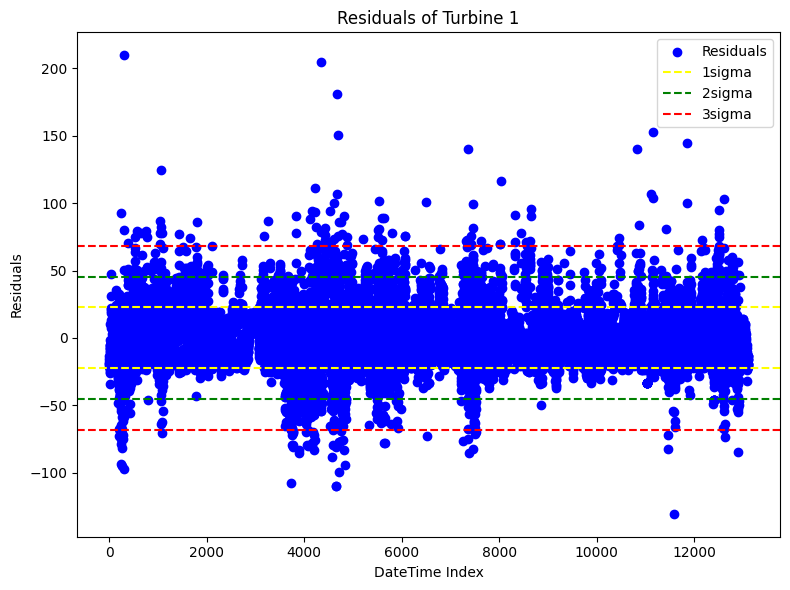

In [42]:
plot_residual(residuals_t1, sigma1_t1, 1)

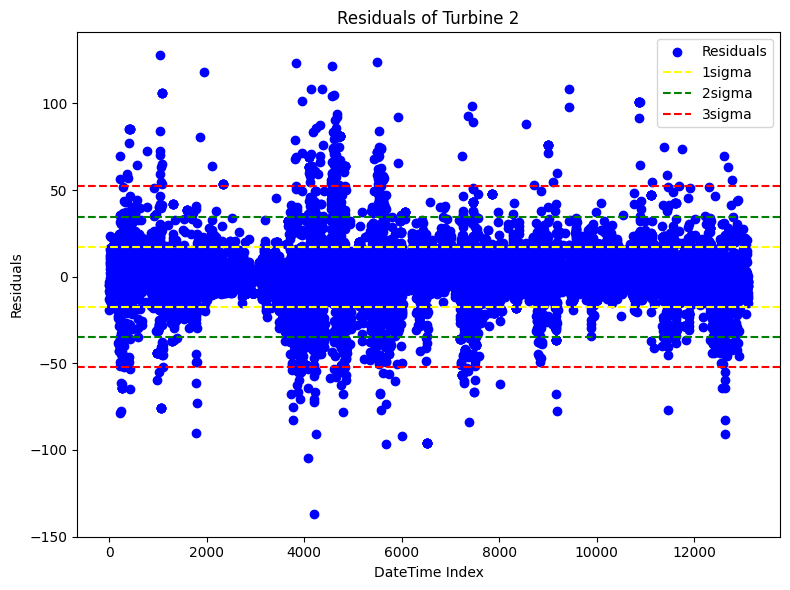

In [43]:
plot_residual(residuals_t2, sigma1_t2, 2)

In [44]:
# Save the anomalous time into new dataframe
anomaly_turbine1 = df_turbine1.iloc[np.where(np.abs(residuals_t1) > 3*sigma1_t1)[0],:]
anomaly_turbine2 = df_turbine2.iloc[np.where(np.abs(residuals_t2) > 3*sigma1_t2)[0],:]

In [45]:
# Function to plot the anomalous ground truths together with the predictions made by model
def plot_anomaly(anomaly_df, preds, turbine_number):
    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(preds))), preds, label='Predictions', color='blue')
    plt.scatter(anomaly_df.index, anomaly_df['Leistung kW'], label='Anomalies', color='red', marker='x')
    plt.xlabel('DateTime Index')
    plt.ylabel('Power kW')
    plt.title('Predictions with anomalous ground truths of Turbine {}'.format(turbine_number))
    plt.legend()
    plt.show()

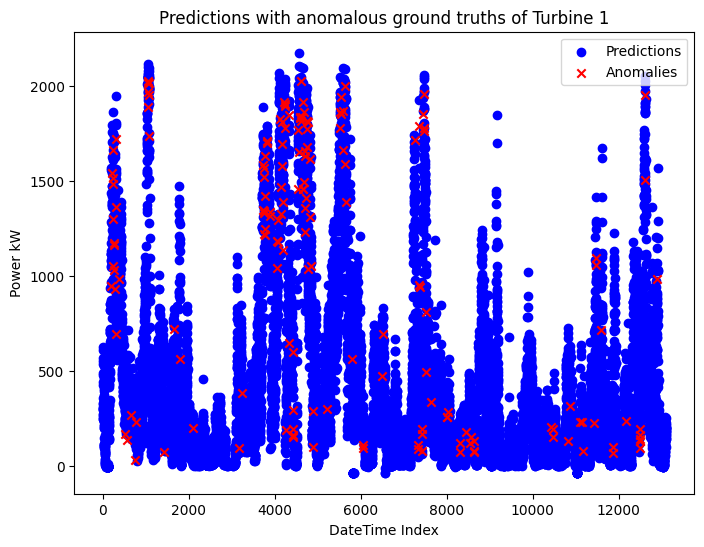

In [46]:
plot_anomaly(anomaly_turbine1, preds_t1_all, 1)

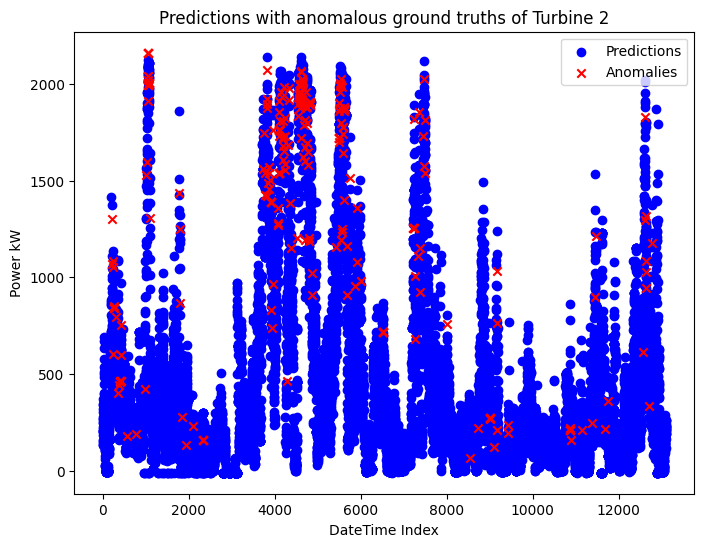

In [47]:
plot_anomaly(anomaly_turbine2, preds_t2_all, 2)

In [48]:
# Function to count the number of anomalies in a certain time interval filtered by a threshold number
def count_anomaly(anomaly_df, time_interval, threshold_num):
    count_df = anomaly_df.resample(time_interval, on='Dat/Zeit').size()
    count_df = count_df.sort_values(ascending=False)
    print(count_df[count_df>threshold_num])
    return count_df

In [49]:
# I used a time interval of 1 hour and a threshold of 3.
count_turbine1 = count_anomaly(anomaly_turbine1, '1H', 3)

Dat/Zeit
2016-03-27 19:00:00    5
2016-01-31 18:00:00    4
dtype: int64


In [50]:
count_turbine2 = count_anomaly(anomaly_turbine2, '1H', 3)

Dat/Zeit
2016-01-28 05:00:00    6
2016-01-03 21:00:00    6
2016-01-29 10:00:00    6
2016-02-08 05:00:00    6
2016-01-29 12:00:00    6
2016-03-16 12:00:00    6
2016-01-08 08:00:00    5
2016-02-02 21:00:00    5
2016-02-15 06:00:00    5
2016-02-03 12:00:00    5
2016-02-08 18:00:00    4
2016-03-03 12:00:00    4
2016-02-20 04:00:00    4
2016-02-20 05:00:00    4
dtype: int64
